In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from itertools import product

np.random.seed(42)

In [38]:
def remove_uniform_square(image, square_size=5, std_threshold=15):
    h, w, c = image.shape
    min_std = float('inf')
    best_coords = (0, 0)

    # Cerco la patch con deviazione standard minima (più uniforme)
    for i in range(h - square_size + 1):
        for j in range(w - square_size + 1):
            patch = image[i:i+square_size, j:j+square_size, :]
            patch_std = np.std(patch, axis=(0,1))
            mean_std = np.mean(patch_std)
            if mean_std < min_std:
                min_std = mean_std
                best_coords = (i, j)

    # Se la deviazione standard è abbastanza bassa, sostituisco la patch
    if min_std < std_threshold:
        i, j = best_coords

        # Prendo il bordo intorno alla patch (se possibile)
        top = max(i-1, 0)
        bottom = min(i+square_size+1, h)
        left = max(j-1, 0)
        right = min(j+square_size+1, w)

        # Prendo i pixel intorno alla patch (bordi esclusi)
        border_pixels = []

        # Riga sopra
        if top < i:
            border_pixels.append(image[top, left:right, :])
        # Riga sotto
        if bottom > i + square_size:
            border_pixels.append(image[bottom-1, left:right, :])
        # Colonna sinistra
        if left < j:
            border_pixels.append(image[top:bottom, left, :])
        # Colonna destra
        if right > j + square_size:
            border_pixels.append(image[top:bottom, right-1, :])

        if border_pixels:
            border_pixels = np.concatenate(border_pixels, axis=0)
            mean_color = np.mean(border_pixels, axis=0)
        else:
            # Se la patch è al bordo, uso il colore medio globale dell'immagine
            mean_color = np.mean(image.reshape(-1, c), axis=0)

        # Sostituisco la patch con il colore medio
        image[i:i+square_size, j:j+square_size, :] = mean_color

    return image

def clean_dataset(images, square_size=5, std_threshold=15):
    cleaned_images = np.empty_like(images)
    for idx in range(images.shape[0]):
        cleaned_images[idx] = remove_uniform_square(images[idx].copy(), square_size, std_threshold)
    return cleaned_images

def plot_examples(orig, cleaned, y, class_names, num_samples=5):
    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        idx = np.random.randint(0, len(orig))
        plt.subplot(2, num_samples, i+1)
        plt.imshow(orig[idx])
        plt.title(f"Original: {class_names[y[idx]]}")
        plt.axis('off')
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(cleaned[idx])
        plt.title(f"Cleaned: {class_names[y[idx]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [39]:
# ----------------------------
# Caricamento dati
# ----------------------------
x_train = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/x_train.npy")
y_train = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/y_train.npy").ravel()
x_val = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/x_val.npy")
y_val = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/y_val.npy").ravel()
x_test = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/x_test.npy")
y_test = np.load("/kaggle/input/cifar10-hw3/cifar_hw3/y_test.npy").ravel()

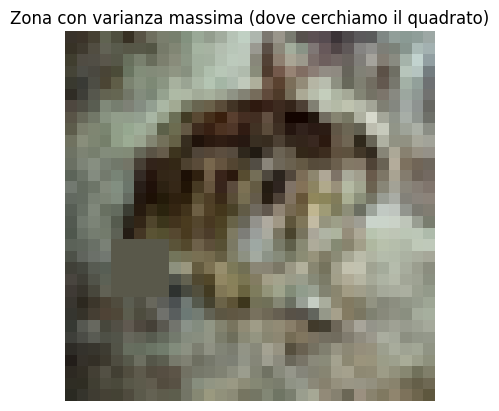

In [40]:
test_img = x_train[0]
highlighted = remove_uniform_square(test_img)
plt.imshow(highlighted)
plt.title("Zona con varianza massima (dove cerchiamo il quadrato)")
plt.axis('off')
plt.show()



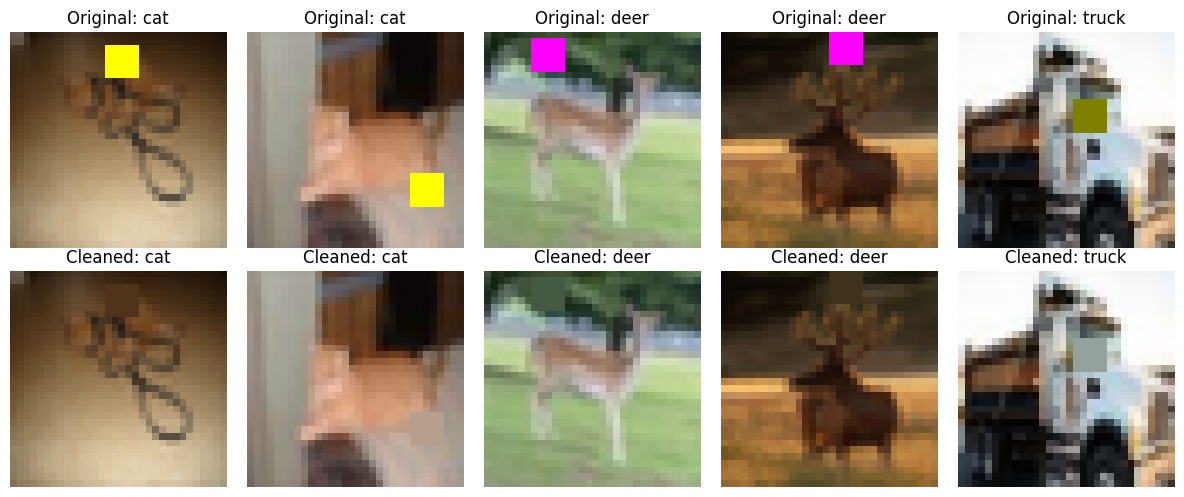

In [41]:
# ----------------------------
# Pulizia immagini (solo sul training set)
# ----------------------------
x_train_cleaned = clean_dataset(x_train, square_size=5, std_threshold=15)

plot_examples(x_train, x_train_cleaned, y_train, class_names)

# ----------------------------
# Preprocessing: flatten + scaling
# ----------------------------
X_train = x_train_cleaned.reshape(x_train_cleaned.shape[0], -1)
X_val = x_val.reshape(x_val.shape[0], -1)
X_test = x_test.reshape(x_test.shape[0], -1)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [42]:
# ----------------------------
# Definizione iperparametri
# ----------------------------
param_grid = {
    'hidden_layer_sizes': [(128, 64), (256, 128)],
    'alpha': [1e-5, 1e-4],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001],
    'max_iter': [100]
}

patience = 5
tolerance = 1e-4

best_val_acc_overall = 0
best_model = None
best_params = None
best_train_accs = []
best_val_accs = []

In [43]:
# ----------------------------
# Grid search + early stopping
# ----------------------------
for hls, alpha, activation, solver, lr_init, max_iter in product(
        param_grid['hidden_layer_sizes'],
        param_grid['alpha'],
        param_grid['activation'],
        param_grid['solver'],
        param_grid['learning_rate_init'],
        param_grid['max_iter']):
    
    print(f"\n--- Training: hls={hls}, alpha={alpha}, activation={activation}, solver={solver}, lr={lr_init}, max_iter={max_iter} ---")
    
    mlp = MLPClassifier(hidden_layer_sizes=hls,
                        alpha=alpha,
                        activation=activation,
                        solver=solver,
                        learning_rate_init=lr_init,
                        max_iter=1,
                        warm_start=True,
                        random_state=42,
                        verbose=False)
    
    best_val_accuracy = 0.0
    epochs_without_improvement = 0
    
    train_accuracies = []
    val_accuracies = []
    
    best_coefs = None
    best_intercepts = None
    
    for epoch in range(max_iter):
        mlp.fit(X_train, y_train)
        train_preds = mlp.predict(X_train)
        val_preds = mlp.predict(X_val)

        train_acc = accuracy_score(y_train, train_preds)
        val_acc = accuracy_score(y_val, val_preds)

        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoca {epoch+1}: Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")
        
        if val_acc > best_val_accuracy + tolerance:
            best_val_accuracy = val_acc
            epochs_without_improvement = 0
            best_coefs = [w.copy() for w in mlp.coefs_]
            best_intercepts = [b.copy() for b in mlp.intercepts_]
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping alla epoca {epoch+1}")
            break

    if best_val_accuracy > best_val_acc_overall:
        best_val_acc_overall = best_val_accuracy
        best_model = mlp
        best_model.coefs_ = best_coefs
        best_model.intercepts_ = best_intercepts
        best_params = {
            'hidden_layer_sizes': hls,
            'alpha': alpha,
            'activation': activation,
            'solver': solver,
            'learning_rate_init': lr_init,
            'max_iter': max_iter
        }
        best_train_accs = train_accuracies
        best_val_accs = val_accuracies


--- Training: hls=(128, 64), alpha=1e-05, activation=relu, solver=adam, lr=0.001, max_iter=100 ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1: Train Acc = 0.4511, Val Acc = 0.4196
Epoca 2: Train Acc = 0.5008, Val Acc = 0.4508
Epoca 3: Train Acc = 0.5314, Val Acc = 0.4639
Epoca 4: Train Acc = 0.5579, Val Acc = 0.4763
Epoca 5: Train Acc = 0.5723, Val Acc = 0.4791
Epoca 6: Train Acc = 0.5883, Val Acc = 0.4812
Epoca 7: Train Acc = 0.5991, Val Acc = 0.4815
Epoca 8: Train Acc = 0.6129, Val Acc = 0.4847
Epoca 9: Train Acc = 0.6259, Val Acc = 0.4882
Epoca 10: Train Acc = 0.6338, Val Acc = 0.4811
Epoca 11: Train Acc = 0.6438, Val Acc = 0.4802
Epoca 12: Train Acc = 0.6499, Val Acc = 0.4779
Epoca 13: Train Acc = 0.6571, Val Acc = 0.4804
Epoca 14: Train Acc = 0.6610, Val Acc = 0.4747
Early stopping alla epoca 14

--- Training: hls=(128, 64), alpha=1e-05, activation=tanh, solver=adam, lr=0.001, max_iter=100 ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1: Train Acc = 0.4116, Val Acc = 0.3911
Epoca 2: Train Acc = 0.4410, Val Acc = 0.4071
Epoca 3: Train Acc = 0.4498, Val Acc = 0.4226
Epoca 4: Train Acc = 0.4688, Val Acc = 0.4285
Epoca 5: Train Acc = 0.4742, Val Acc = 0.4294
Epoca 6: Train Acc = 0.4846, Val Acc = 0.4357
Epoca 7: Train Acc = 0.4957, Val Acc = 0.4373
Epoca 8: Train Acc = 0.5026, Val Acc = 0.4400
Epoca 9: Train Acc = 0.5134, Val Acc = 0.4344
Epoca 10: Train Acc = 0.5215, Val Acc = 0.4350
Epoca 11: Train Acc = 0.5301, Val Acc = 0.4364
Epoca 12: Train Acc = 0.5393, Val Acc = 0.4379
Epoca 13: Train Acc = 0.5472, Val Acc = 0.4422
Epoca 14: Train Acc = 0.5563, Val Acc = 0.4446
Epoca 15: Train Acc = 0.5631, Val Acc = 0.4411
Epoca 16: Train Acc = 0.5757, Val Acc = 0.4411
Epoca 17: Train Acc = 0.5753, Val Acc = 0.4419
Epoca 18: Train Acc = 0.5829, Val Acc = 0.4337
Epoca 19: Train Acc = 0.5826, Val Acc = 0.4391
Early stopping alla epoca 19

--- Training: hls=(128, 64), alpha=0.0001, activation=relu, solver=adam, lr=0.001, max

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1: Train Acc = 0.4581, Val Acc = 0.4233
Epoca 2: Train Acc = 0.5007, Val Acc = 0.4501
Epoca 3: Train Acc = 0.5257, Val Acc = 0.4604
Epoca 4: Train Acc = 0.5518, Val Acc = 0.4688
Epoca 5: Train Acc = 0.5760, Val Acc = 0.4838
Epoca 6: Train Acc = 0.5891, Val Acc = 0.4829
Epoca 7: Train Acc = 0.6039, Val Acc = 0.4821
Epoca 8: Train Acc = 0.6113, Val Acc = 0.4826
Epoca 9: Train Acc = 0.6257, Val Acc = 0.4874
Epoca 10: Train Acc = 0.6334, Val Acc = 0.4812
Epoca 11: Train Acc = 0.6451, Val Acc = 0.4846
Epoca 12: Train Acc = 0.6475, Val Acc = 0.4797
Epoca 13: Train Acc = 0.6532, Val Acc = 0.4732
Epoca 14: Train Acc = 0.6611, Val Acc = 0.4743
Early stopping alla epoca 14

--- Training: hls=(128, 64), alpha=0.0001, activation=tanh, solver=adam, lr=0.001, max_iter=100 ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1: Train Acc = 0.4115, Val Acc = 0.3847
Epoca 2: Train Acc = 0.4346, Val Acc = 0.4074
Epoca 3: Train Acc = 0.4484, Val Acc = 0.4161
Epoca 4: Train Acc = 0.4650, Val Acc = 0.4256
Epoca 5: Train Acc = 0.4708, Val Acc = 0.4309
Epoca 6: Train Acc = 0.4867, Val Acc = 0.4327
Epoca 7: Train Acc = 0.4921, Val Acc = 0.4311
Epoca 8: Train Acc = 0.5011, Val Acc = 0.4343
Epoca 9: Train Acc = 0.5092, Val Acc = 0.4360
Epoca 10: Train Acc = 0.5196, Val Acc = 0.4400
Epoca 11: Train Acc = 0.5277, Val Acc = 0.4398
Epoca 12: Train Acc = 0.5305, Val Acc = 0.4430
Epoca 13: Train Acc = 0.5440, Val Acc = 0.4435
Epoca 14: Train Acc = 0.5503, Val Acc = 0.4476
Epoca 15: Train Acc = 0.5582, Val Acc = 0.4383
Epoca 16: Train Acc = 0.5702, Val Acc = 0.4395
Epoca 17: Train Acc = 0.5730, Val Acc = 0.4414
Epoca 18: Train Acc = 0.5781, Val Acc = 0.4384
Epoca 19: Train Acc = 0.5848, Val Acc = 0.4350
Early stopping alla epoca 19

--- Training: hls=(256, 128), alpha=1e-05, activation=relu, solver=adam, lr=0.001, max

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1: Train Acc = 0.4663, Val Acc = 0.4263
Epoca 2: Train Acc = 0.5076, Val Acc = 0.4549
Epoca 3: Train Acc = 0.5463, Val Acc = 0.4741
Epoca 4: Train Acc = 0.5713, Val Acc = 0.4826
Epoca 5: Train Acc = 0.5917, Val Acc = 0.4826
Epoca 6: Train Acc = 0.6119, Val Acc = 0.4875
Epoca 7: Train Acc = 0.6294, Val Acc = 0.4860
Epoca 8: Train Acc = 0.6495, Val Acc = 0.4831
Epoca 9: Train Acc = 0.6680, Val Acc = 0.4842
Epoca 10: Train Acc = 0.6682, Val Acc = 0.4813
Epoca 11: Train Acc = 0.6793, Val Acc = 0.4779
Early stopping alla epoca 11

--- Training: hls=(256, 128), alpha=1e-05, activation=tanh, solver=adam, lr=0.001, max_iter=100 ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1: Train Acc = 0.4263, Val Acc = 0.3936
Epoca 2: Train Acc = 0.4572, Val Acc = 0.4091
Epoca 3: Train Acc = 0.4777, Val Acc = 0.4268
Epoca 4: Train Acc = 0.4939, Val Acc = 0.4363
Epoca 5: Train Acc = 0.5098, Val Acc = 0.4370
Epoca 6: Train Acc = 0.5235, Val Acc = 0.4394
Epoca 7: Train Acc = 0.5360, Val Acc = 0.4463
Epoca 8: Train Acc = 0.5486, Val Acc = 0.4437
Epoca 9: Train Acc = 0.5576, Val Acc = 0.4419
Epoca 10: Train Acc = 0.5718, Val Acc = 0.4411
Epoca 11: Train Acc = 0.5850, Val Acc = 0.4394
Epoca 12: Train Acc = 0.5936, Val Acc = 0.4407
Early stopping alla epoca 12

--- Training: hls=(256, 128), alpha=0.0001, activation=relu, solver=adam, lr=0.001, max_iter=100 ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1: Train Acc = 0.4693, Val Acc = 0.4360
Epoca 2: Train Acc = 0.5092, Val Acc = 0.4521
Epoca 3: Train Acc = 0.5423, Val Acc = 0.4657
Epoca 4: Train Acc = 0.5705, Val Acc = 0.4733
Epoca 5: Train Acc = 0.5920, Val Acc = 0.4781
Epoca 6: Train Acc = 0.6208, Val Acc = 0.4858
Epoca 7: Train Acc = 0.6359, Val Acc = 0.4923
Epoca 8: Train Acc = 0.6465, Val Acc = 0.4882
Epoca 9: Train Acc = 0.6551, Val Acc = 0.4823
Epoca 10: Train Acc = 0.6734, Val Acc = 0.4821
Epoca 11: Train Acc = 0.6772, Val Acc = 0.4745
Epoca 12: Train Acc = 0.6834, Val Acc = 0.4724
Early stopping alla epoca 12

--- Training: hls=(256, 128), alpha=0.0001, activation=tanh, solver=adam, lr=0.001, max_iter=100 ---


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(


Epoca 1: Train Acc = 0.4228, Val Acc = 0.4012
Epoca 2: Train Acc = 0.4528, Val Acc = 0.4147
Epoca 3: Train Acc = 0.4742, Val Acc = 0.4307
Epoca 4: Train Acc = 0.4944, Val Acc = 0.4359
Epoca 5: Train Acc = 0.5103, Val Acc = 0.4372
Epoca 6: Train Acc = 0.5220, Val Acc = 0.4424
Epoca 7: Train Acc = 0.5359, Val Acc = 0.4520
Epoca 8: Train Acc = 0.5477, Val Acc = 0.4535
Epoca 9: Train Acc = 0.5651, Val Acc = 0.4511
Epoca 10: Train Acc = 0.5711, Val Acc = 0.4470
Epoca 11: Train Acc = 0.5826, Val Acc = 0.4500
Epoca 12: Train Acc = 0.5925, Val Acc = 0.4444
Epoca 13: Train Acc = 0.6069, Val Acc = 0.4539
Epoca 14: Train Acc = 0.6194, Val Acc = 0.4499
Epoca 15: Train Acc = 0.6245, Val Acc = 0.4443
Epoca 16: Train Acc = 0.6415, Val Acc = 0.4515
Epoca 17: Train Acc = 0.6478, Val Acc = 0.4497
Epoca 18: Train Acc = 0.6562, Val Acc = 0.4456
Early stopping alla epoca 18



Migliori parametri: {'hidden_layer_sizes': (256, 128), 'alpha': 0.0001, 'activation': 'relu', 'solver': 'adam', 'learning_rate_init': 0.001, 'max_iter': 100}
Migliore accuratezza di validazione: 0.4923

Accuracy finale sul test set: 0.4908

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55      1000
           1       0.62      0.55      0.58      1000
           2       0.40      0.37      0.38      1000
           3       0.37      0.23      0.28      1000
           4       0.43      0.35      0.39      1000
           5       0.41      0.43      0.42      1000
           6       0.47      0.66      0.55      1000
           7       0.52      0.59      0.55      1000
           8       0.59      0.62      0.60      1000
           9       0.51      0.57      0.54      1000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.

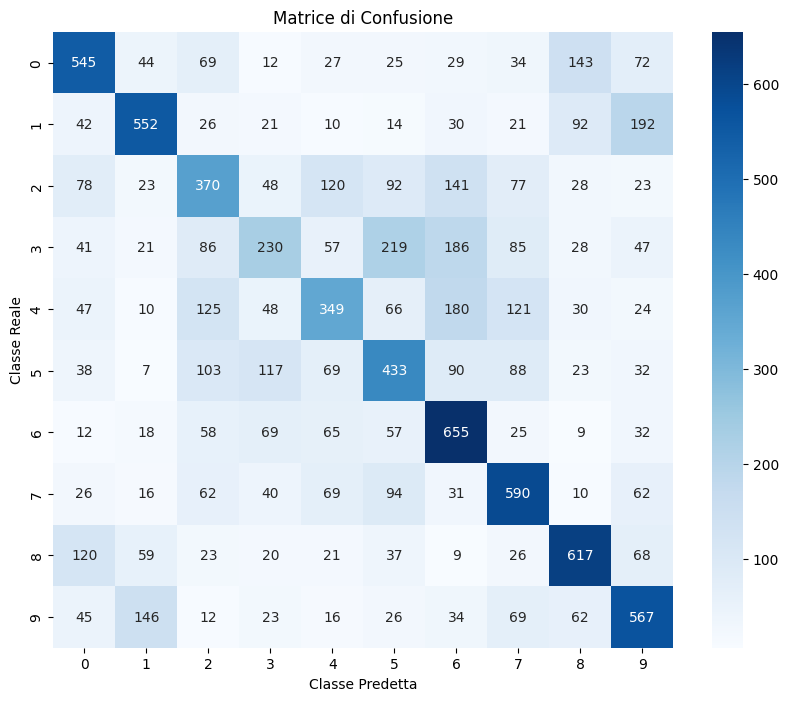

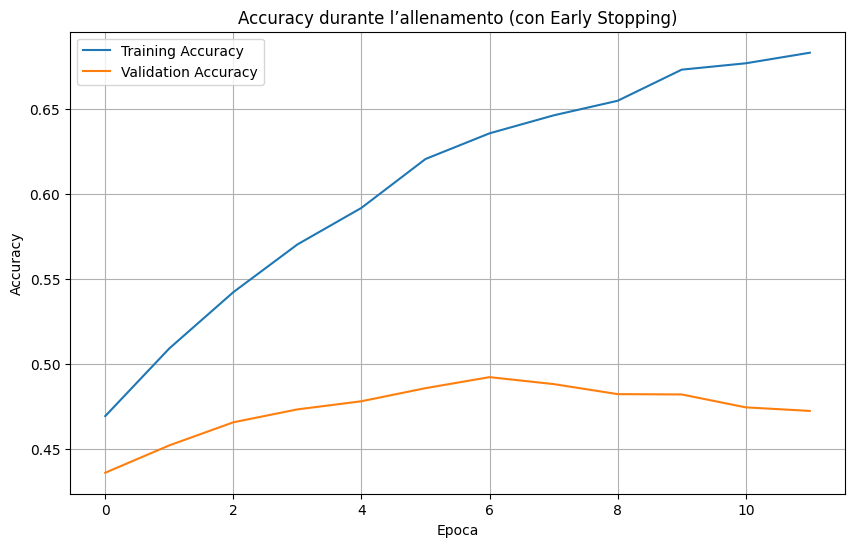

In [44]:
# ----------------------------
# Valutazione finale
# ----------------------------
print(f"\nMigliori parametri: {best_params}")
print(f"Migliore accuratezza di validazione: {best_val_acc_overall:.4f}")

test_preds = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"\nAccuracy finale sul test set: {test_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, test_preds))

cm = confusion_matrix(y_test, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice di Confusione")
plt.xlabel("Classe Predetta")
plt.ylabel("Classe Reale")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(best_train_accs, label='Training Accuracy')
plt.plot(best_val_accs, label='Validation Accuracy')
plt.title('Accuracy durante l’allenamento (con Early Stopping)')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()